## Загрузка и подготовка данных

In [2]:
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
transactions_df = pd.read_parquet('transaction_fraud_data.parquet')
exchange_df = pd.read_parquet('historical_currency_exchange.parquet')

In [4]:
transactions_df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [5]:
exchange_df.head()

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


#### Раскрываю вложенную колонку `last_hour_activity`

In [6]:
lha_df = pd.json_normalize(transactions_df['last_hour_activity'])
lha_df.columns = [f'lha_{col}' for col in lha_df.columns]
df = pd.concat([transactions_df.drop('last_hour_activity', axis=1), lha_df], axis=1)

In [7]:
df['date'] = df['timestamp'].dt.date
exchange_df['date'] = pd.to_datetime(exchange_df['date']).dt.date

In [8]:
merged = pd.merge(df, exchange_df, on='date', how='left')

In [10]:
def convert_to_usd(row):
    amount = row['amount']
    currency = row['currency']
    
    if currency in exchange_df.columns:
        rate = row[currency]
        return amount / rate
    
merged['amount_usd'] = merged.apply(convert_to_usd, axis=1)

### EDA

In [11]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [15]:
fraud_rate = merged['is_fraud'].value_counts(normalize=True) * 100
print(f"\nСоотношение классов:\n{fraud_rate}")


Соотношение классов:
is_fraud
False    80.027182
True     19.972818
Name: proportion, dtype: float64


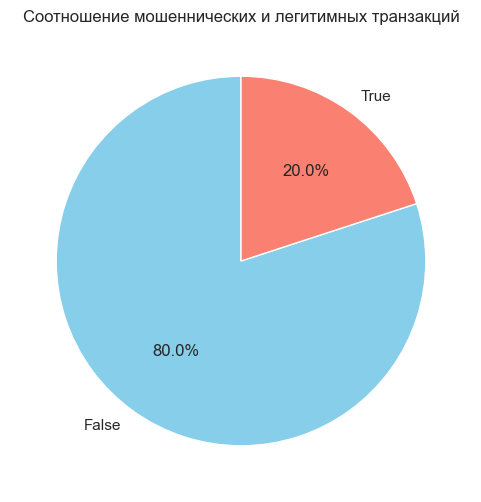

Инсайт: Данные сильно несбалансированы. Это типично для задач обнаружения мошенничества.


In [16]:
plt.figure(figsize=(6, 6))
merged['is_fraud'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Соотношение мошеннических и легитимных транзакций')
plt.ylabel('')
plt.show()
print("Инсайт: Данные сильно несбалансированы. Это типично для задач обнаружения мошенничества.")

In [20]:
merged.query('currency == "RUB"').head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD,amount_usd
10,TX_77c32a20,CUST_64274,4669676651762818,2024-09-30 00:00:07.583345,Gas,major,Exxon,34644.57,RUB,Russia,...,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,368.035646
13,TX_6da72d5a,CUST_42282,375133309224224,2024-09-30 00:00:10.953172,Grocery,online,FreshDirect,36.99,RUB,Russia,...,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,0.392952
33,TX_eecf6c3b,CUST_67064,4906576640072944,2024-09-30 00:00:31.366348,Retail,online,Etsy,113801.86,RUB,Russia,...,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,1208.938111
41,TX_ae0e0a18,CUST_28619,4927000937791194,2024-09-30 00:00:37.734117,Restaurant,fast_food,Wendy's,311.02,RUB,Russia,...,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,3.304023
53,TX_1004b116,CUST_36268,5020251197983855,2024-09-30 00:00:49.499688,Gas,major,Chevron,14419.77,RUB,Russia,...,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1,153.183872


c:\Users\vladk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vladk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\vladk\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\vladk\App

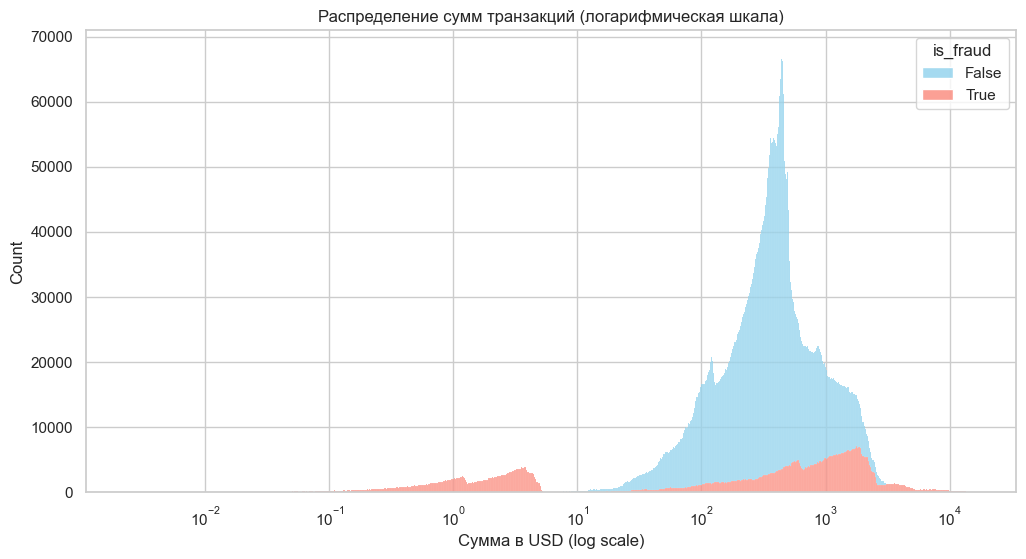

Инсайт: Мошеннические транзакции (красный) имеют тенденцию либо к большим суммам, либо к очень маленьким по сравнению с легитимными.


In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(data=merged, x='amount_usd', hue='is_fraud', log_scale=True, multiple='stack', palette=['skyblue', 'salmon'])
plt.title('Распределение сумм транзакций (логарифмическая шкала)')
plt.xlabel('Сумма в USD (log scale)')
plt.show()
print("Инсайт: Мошеннические транзакции (красный) имеют тенденцию либо к большим суммам, либо к очень маленьким по сравнению с легитимными.")

In [40]:
def plot_fraud_rate_by_category(df, column, title):
    fraud_rate_by_cat = df.groupby(column)['is_fraud'].mean().sort_values(ascending=False)
    print(fraud_rate_by_cat)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=fraud_rate_by_cat.index, y=fraud_rate_by_cat.values, palette='viridis')
    plt.title(title)
    plt.ylabel('Доля мошеннических транзакций')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.show()

vendor_category
Travel           0.200341
Grocery          0.200194
Gas              0.199731
Restaurant       0.199696
Entertainment    0.199632
Education        0.199459
Retail           0.199398
Healthcare       0.199376
Name: is_fraud, dtype: float64


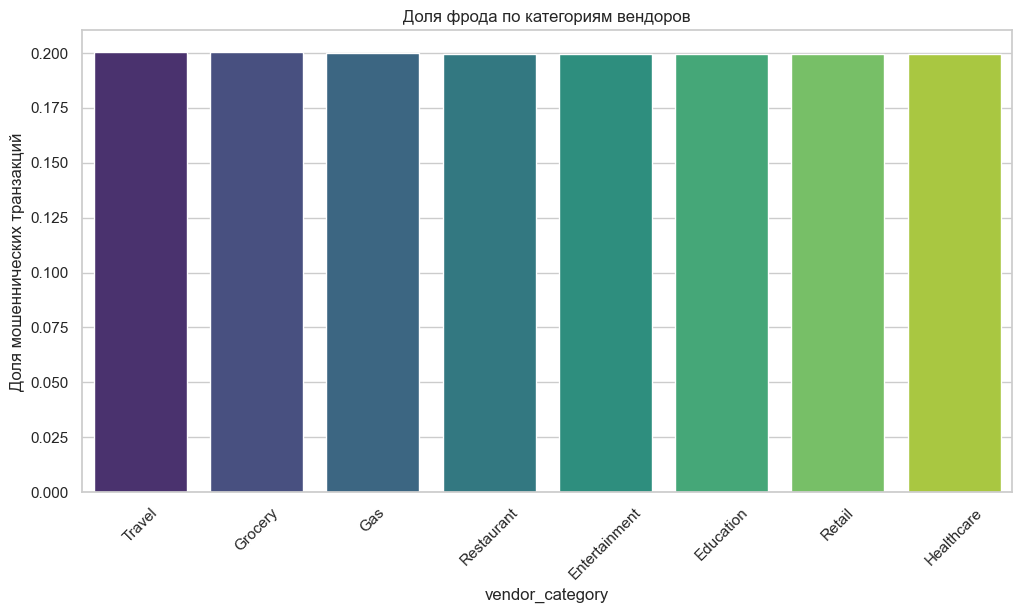

Инсайт: Все категории показывают примерно одинаковый уровень мошенничества.


In [35]:
plot_fraud_rate_by_category(merged, 'vendor_category', 'Доля фрода по категориям вендоров')
print("Инсайт: Все категории показывают примерно одинаковый уровень мошенничества.")

channel
pos       1.000000
mobile    0.123878
web       0.123275
Name: is_fraud, dtype: float64


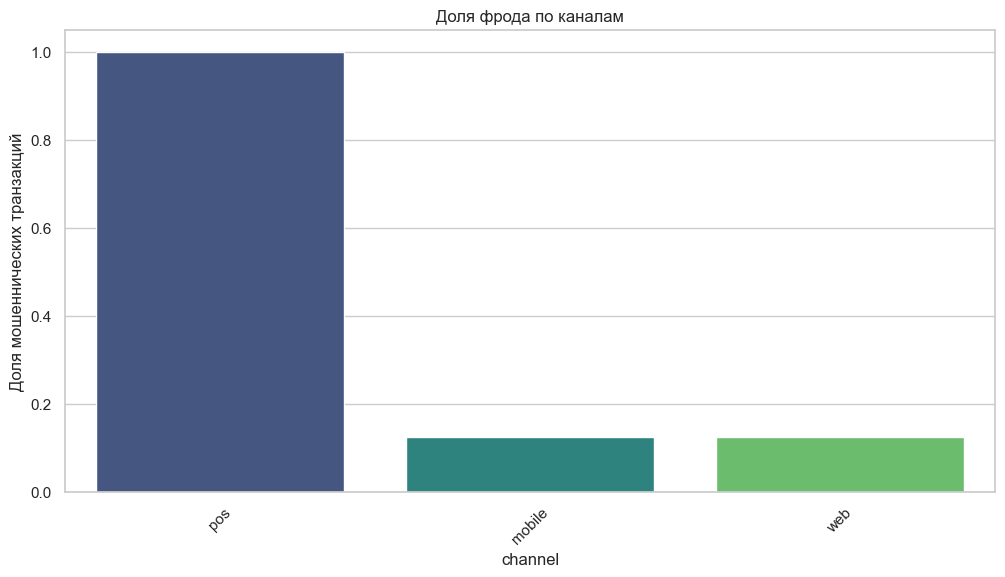

Инсайт: 'pos' канал является самым рискованным.


In [36]:
plot_fraud_rate_by_category(merged, 'channel', 'Доля фрода по каналам')
print("Инсайт: 'pos' канал является самым рискованным.")

is_card_present
True     1.000000
False    0.123475
Name: is_fraud, dtype: float64


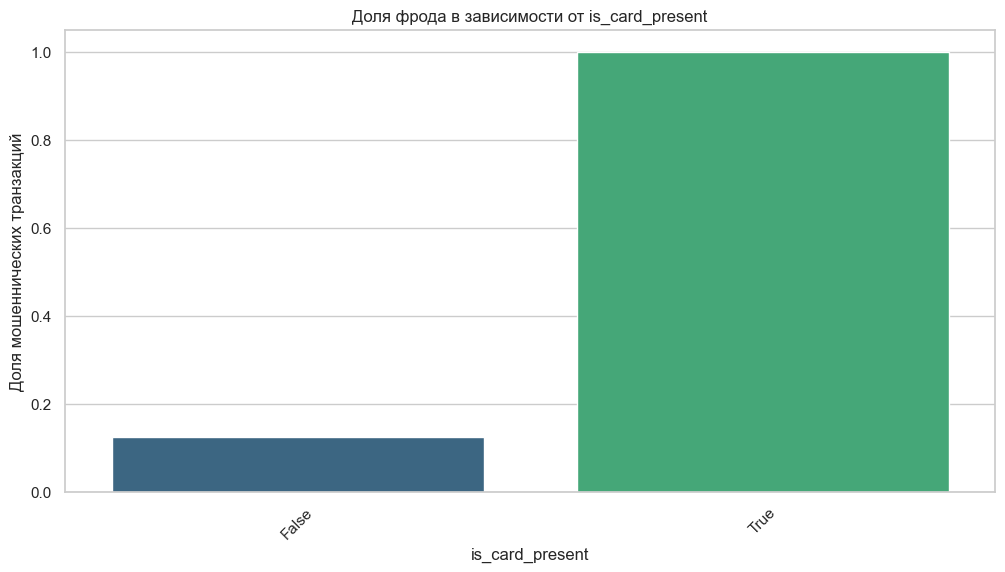

is_outside_home_country
True     0.567753
False    0.024902
Name: is_fraud, dtype: float64


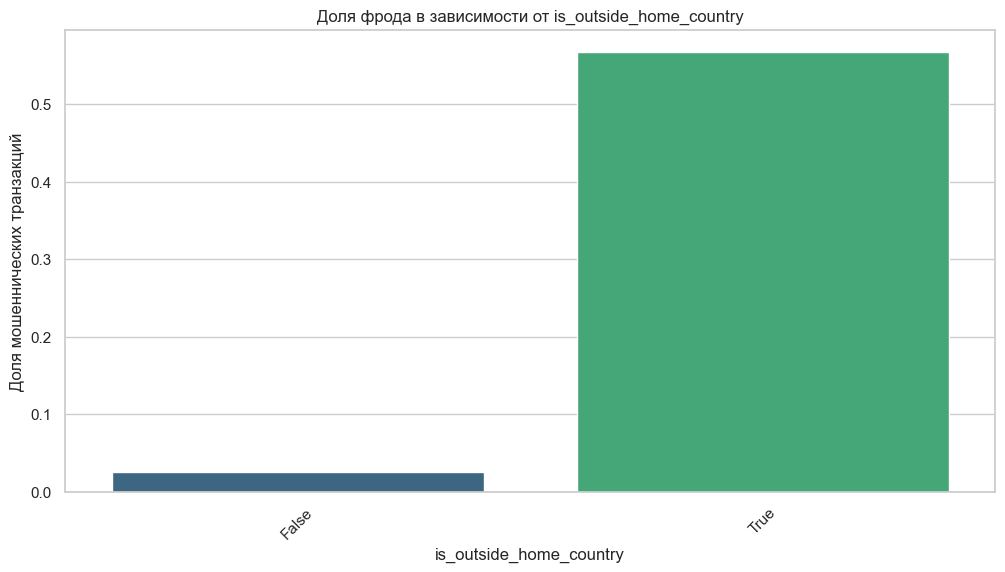

is_high_risk_vendor
True     0.199986
False    0.199642
Name: is_fraud, dtype: float64


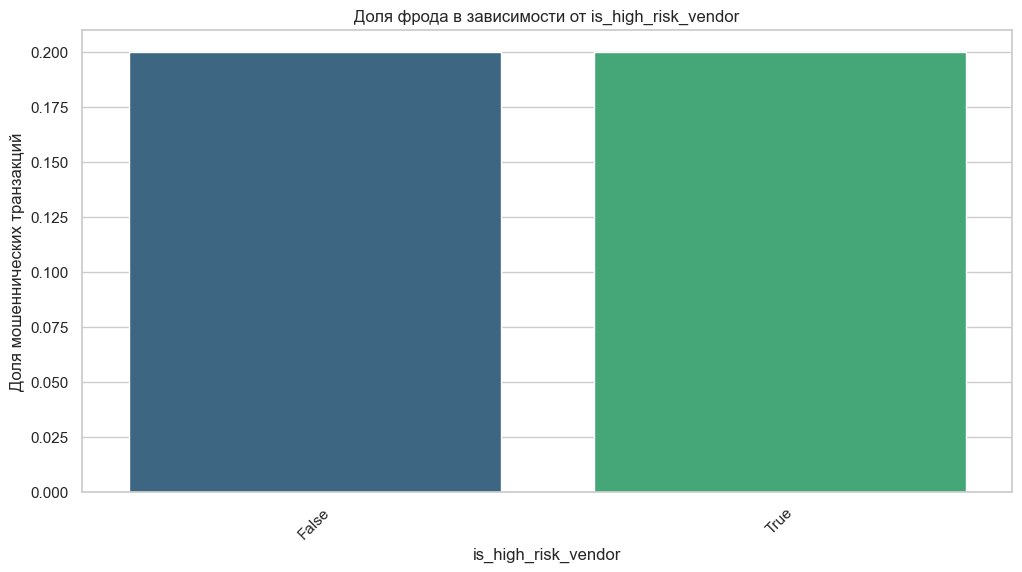

In [41]:
binary_features = ['is_card_present', 'is_outside_home_country', 'is_high_risk_vendor']
for feature in binary_features:
    plot_fraud_rate_by_category(merged, feature, f'Доля фрода в зависимости от {feature}')

In [42]:
print("Инсайты:")
print("- Транзакции с физическим присутствии карты намного более рискованны.")
print("- Операции за пределами домашней страны клиента также показывают высокий риск.")

Инсайты:
- Транзакции с физическим присутствии карты намного более рискованны.
- Операции за пределами домашней страны клиента также показывают высокий риск.


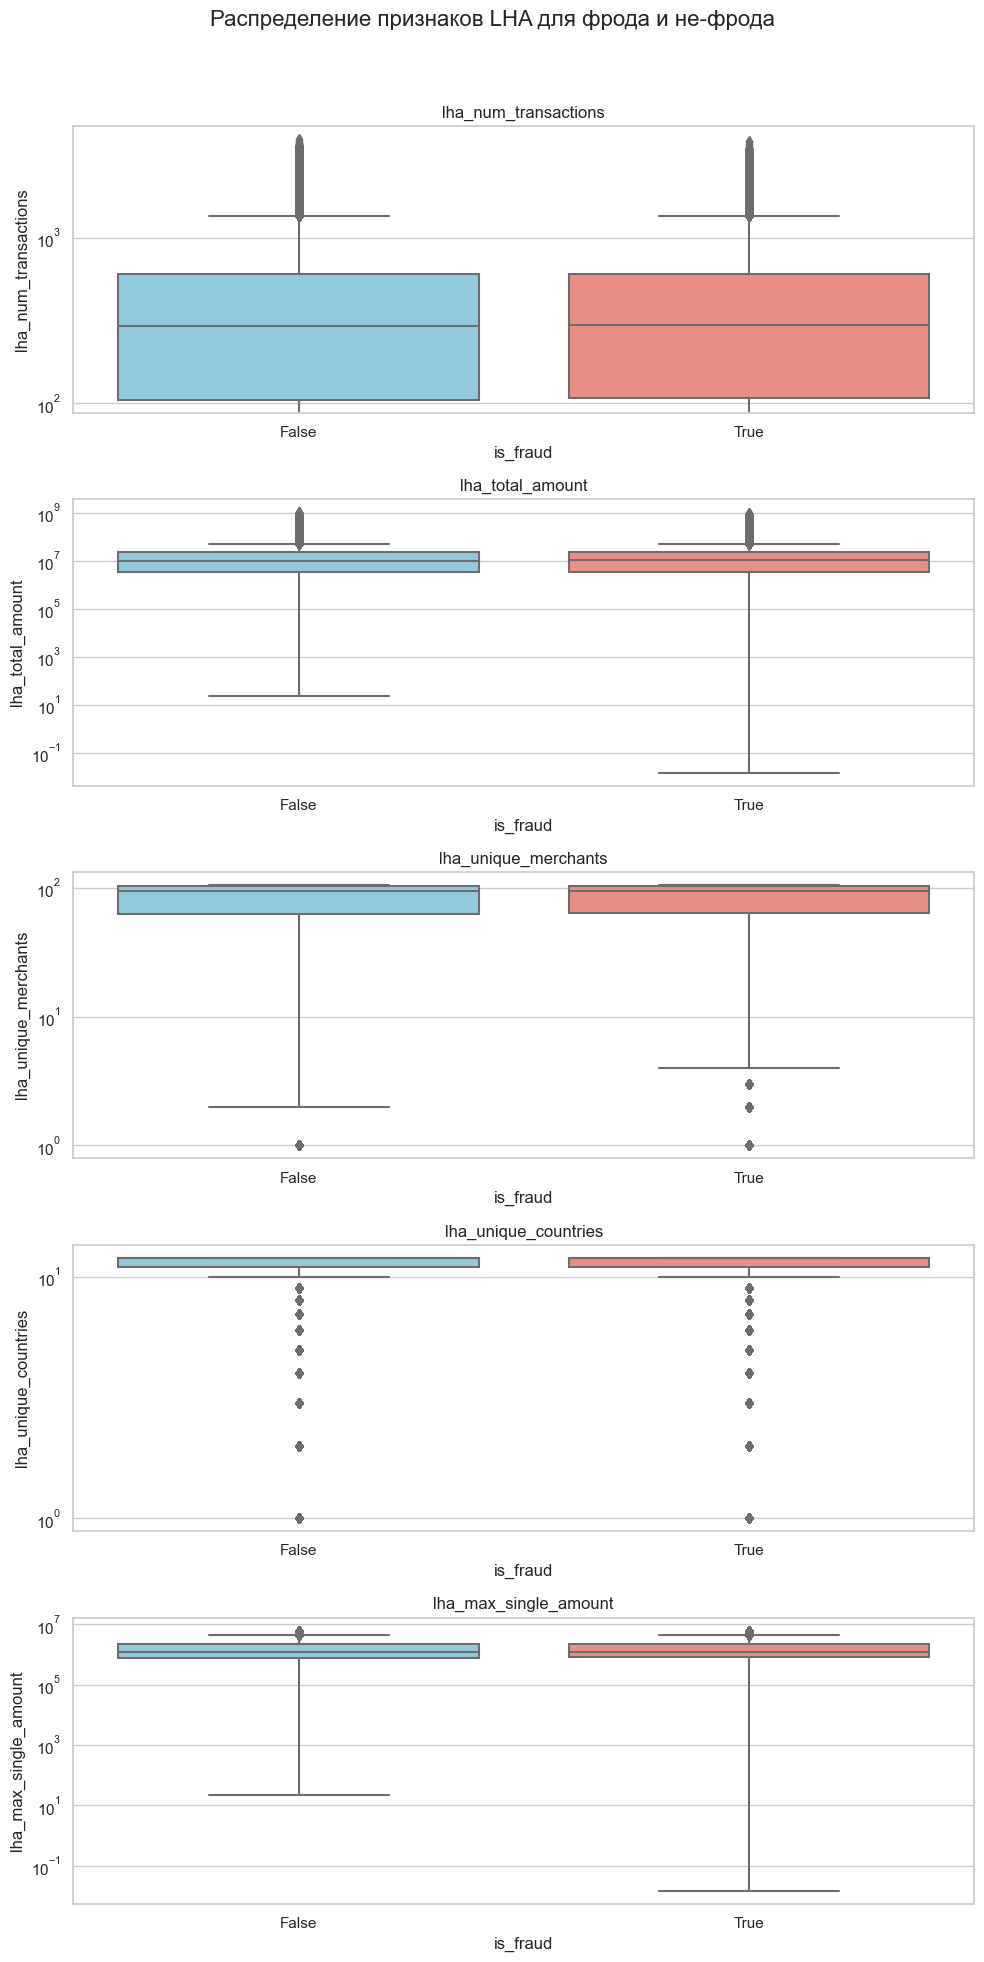

Инсайт: Все признаки из `last_hour_activity` не являются мощными предикторами, фичи для fraud и not fraud имеют схожие распределения


In [47]:
lha_cols = [col for col in merged.columns if 'lha_' in col]
fig, axes = plt.subplots(len(lha_cols), 1, figsize=(10, 20))
fig.suptitle('Распределение признаков LHA для фрода и не-фрода', fontsize=16)

for i, col in enumerate(lha_cols):
    sns.boxplot(x='is_fraud', y=col, data=merged, ax=axes[i], palette=['skyblue', 'salmon'])
    axes[i].set_title(col)
    axes[i].set_yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("Инсайт: Все признаки из `last_hour_activity` не являются мощными предикторами, фичи для fraud и not fraud имеют схожие распределения")

## Гипотезы

В качестве средства для генерации отчёта я предложил LLM(Gemini 2.5 Pro) сгенерировать запросы, из которых можно получить инсайты. По инсайтам и графикам я попросил составить продуктовые и тестовые гипотезы, которые дополнительно подредактировал.

### Продуктовые гипотезы

1.  **Гипотеза о геолокационной верификации в реальном времени**:
    *   **Наблюдение**: Риск высок при `is_card_present=True` и `is_outside_home_country=True`.
    *   **Гипотеза**: Если мы внедрим систему, которая при POS-транзакции за рубежом сверяет геолокацию транзакции с геолокацией мобильного устройства клиента, мы сможем с высокой точностью блокировать фрод с клонированными картами. Если телефон клиента в одной стране, а карта используется в другой — это почти 100% фрод.
    *   **Ценность**: Сверхэффективная блокировка самого очевидного сценария мошенничества с клонированными картами. Минимальное количество ложных срабатываний, так как добросовестный клиент путешествует вместе со своим телефоном.

2.  **Гипотеза об "умных" уведомлениях на аномальные суммы**:
    *   **Наблюдение**: Фрод имеет биполярное распределение сумм (очень маленькие или очень большие).
    *   **Гипотеза**: Создание системы мгновенных push-уведомлений, которые срабатывают не на все транзакции, а только на те, что попадают в аномальные зоны:
        *   **"Card Testing Alert"**: Транзакция на сумму < $1.00. Уведомление: *"Только что была совершена покупка на $0.50. Если это были не вы, немедленно заблокируйте карту."*
        *   **"Large Purchase Alert"**: Транзакция, превышающая 95-й перцентиль *обычных* трат клиента. Уведомление: *"Подтвердите покупку на $2500 в магазине X. Это вы?"*
    *   **Ценность**: Проактивное вовлечение клиента в процесс защиты его средств. Позволяет остановить "кэш-аут" после успешного "теста", давая клиенту возможность быстро среагировать.

3.  **Гипотеза о риск-скоринге POS-терминалов, а не категорий**:
    *   **Наблюдение**: Категории вендоров не важны, но фрод происходит на конкретных `POS`-терминалах.
    *   **Гипотеза**: Вместо скоринга категорий, следует создать систему репутационного скоринга для отдельных торговых точек или даже конкретных POS-терминалов (если есть такой ID). Если через один и тот же терминал в условном "сувенирном магазине" в туристической зоне прошло несколько мошеннических операций по картам разных клиентов, этот терминал должен быть помечен как высокорисковый, и все последующие транзакции через него должны проходить дополнительную проверку.
    *   **Ценность**: Выявление и изоляция скомпрометированных точек продаж (где установлен скиммер), защита всех клиентов банка от этого источника угрозы.

---

### Технические гипотезы

1.  **Гипотеза о пересмотре важности признаков**:
    *   **Наблюдение**: `last_hour_activity` и `vendor_category` бесполезны. `is_card_present`, `channel='pos'`, `is_outside_home_country` и `amount_usd` — ключевые.
    *   **Гипотеза**: Модель градиентного бустинга должна быть построена на новом наборе сильных признаков. Признаки `last_hour_activity` следует исключить из модели, чтобы не добавлять шум. Ключевыми будут бинарные флаги и сумма, а также их взаимодействия.
    *   **Ценность**: Построение более простой, интерпретируемой и точной модели, которая фокусируется на реальных сигналах, присутствующих в данных, а не на ложных корреляциях.

2.  **Гипотеза о нелинейной зависимости от суммы**:
    *   **Наблюдение**: Сумма фрода имеет бимодальное распределение.
    *   **Гипотеза**: Модели будет сложно уловить эту зависимость. Следует создать новые признаки (Feature Engineering), которые явно кодируют этот паттерн:
        *   `is_micro_transaction` = `amount_usd < 1`
        *   `is_macro_transaction` = `amount_usd > df['amount_usd'].quantile(0.99)`
        *   `amount_deviation_from_mean` = `abs(amount_usd - customer_average_amount)`
    *   **Ценность**: Явное указание модели на аномальные суммы значительно повысит её способность обнаруживать как "тесты карт", так и "кэш-ауты". Это упростит работу для tree-based моделей и сделает их более робастными.
